In [1]:
from maelzel.core import *
from pitchtools import *

## Config

Within *maelzel.core* **there is, at any moment, an active config object** (an instance of `CoreConfig`). This config encompasses settings related to notation, playback, quantization and many other aspects of *maelzel.core*. It is a subclass of *dict* with a fixed set of possible keys

In [2]:
# Get the active config
conf = getConfig()
conf

Key,Value,Type,Descr
A4,442,between 10 - 10000,"Freq. of the Kammerton A4. Normal values are 440, 442, 443 or 432 for old tuning, but any 'fantasy' value can be used"
splitAcceptableDeviation,4,type: int,"When splitting notes between staves, notes within this range of the split point will be grouped together if they all fit"
chordAdjustGain,True,type: bool,"Adjust the gain of a chord according to the number of notes, to prevent clipping"
reprShowFreq,False,type: bool,Show frequency when printing a Note in the console
semitoneDivisions,4,"{1, 2, 4}","The number of divisions per semitone (2=quarter-tones, 4=eighth-tones)"
musescorepath,,type: str,The command to use when calling MuseScore. For macOS users: it must be an absolute path pointing to the actual binary inside the .app bundle
show.arpeggiateChord,auto,"{auto, False, True}","Arpeggiate notes of a chord when showing. In auto mode, only arpeggiate when needed"
show.lastBreakpointDur,0.125,between 0.015625 - 1,"Dur of a note representing the end of a line/gliss, which has no duration per se"
show.cents,True,type: bool,show cents deviation as text when rendering notation
show.centsFontSize,8,type: int,Font size used for cents annotations


**The config is at its core a dict where only a well defined set of keys are allowed and values are validated**. All operations on a built-in dict can be performed. 
To create a new configuration with some values modified, call `.clone` on any config. Creating a new config via `CoreConfig` will create a copy of the last persisted
config.

As an example, here we **create a new config** as a clone of the root config with a custom reference frequency. This modifies the reference frequency for any operation converting frequency to midinote or note name. After evaluating the following cell one can confirm that a frequency of 442 Hz is now 12 cents lower than A4

In [3]:
conf = CoreConfig({'A4': 445}, active=True)
conf

Key,Value,Type,Descr
A4,* 445,between 10 - 10000 | default: 442,"Freq. of the Kammerton A4. Normal values are 440, 442, 443 or 432 for old tuning, but any 'fantasy' value can be used"
splitAcceptableDeviation,4,type: int,"When splitting notes between staves, notes within this range of the split point will be grouped together if they all fit"
chordAdjustGain,True,type: bool,"Adjust the gain of a chord according to the number of notes, to prevent clipping"
reprShowFreq,False,type: bool,Show frequency when printing a Note in the console
semitoneDivisions,4,"{1, 2, 4}","The number of divisions per semitone (2=quarter-tones, 4=eighth-tones)"
musescorepath,,type: str,The command to use when calling MuseScore. For macOS users: it must be an absolute path pointing to the actual binary inside the .app bundle
show.arpeggiateChord,auto,"{auto, False, True}","Arpeggiate notes of a chord when showing. In auto mode, only arpeggiate when needed"
show.lastBreakpointDur,0.125,between 0.015625 - 1,"Dur of a note representing the end of a line/gliss, which has no duration per se"
show.cents,True,type: bool,show cents deviation as text when rendering notation
show.centsFontSize,8,type: int,Font size used for cents annotations


In [4]:
f2n(442)

'4A-12'

To restore the original frequency, just modify the value of the active config:

In [5]:
getConfig()['A4'] = 442
f2n(442)

'4A'

Or activate the previous config

In [6]:
conf.activate()
f2n(442)

'4A'

-----------------

## Validation

A `CoreConfig` is also aware about valid values for its keys. For example, it is possible to customize the number of playback channels used by the sound engine, or the
latency used for scheduling events. 

In [7]:
# Set the default number of channels for playback. Any playback engine created will use this setting
conf['play.numChannels'] = 4
conf['play.schedLatency'] = 0.1

A wrong type or range will throw an error and the previous value will not be overwritten so that the configuration remains in a usable state.

In [8]:
conf['play.numChannels'] = 'four'

ValueError: Expected int for key play.numChannels, got str

## Persistence

Customizations can be made persistent by calling `save` on the dictionary (independently of it being active). After that, any config created in a future session will use this dict as its prototype

In [5]:
conf.save()

To revert a config to its factory defaults, use `reset`

In [8]:
conf.reset()
conf['play.numChannels']

2

## Customizing playback / recording

By default any Note/Chord is played back using the default instr, which is a built-in piano soundfont. It is possible to customize the default instrument: 

In [9]:
defPresetSoundfont("accordion", "/home/em/Lib/snd/sf2/Accordion.sf2")

Preset: accordion  
    hasRouting=True, properties={'sfpath': '/home/em/Lib/snd/sf2/Accordion.sf2'}
  init: iSfTable_ sfloadonce "/home/em/Lib/snd/sf2/Accordion.sf2"
  ipresetidx sfPresetIndex "/home/em/Lib/snd/sf2/Accordion.sf2", 0, 0
  inote0_ = round(p(idataidx_ + 1))
  ivel_ = p(idataidx_ + 2) * 127
  aout1, aout2 sfplay ivel_, inote0_, kamp/16384, mtof:k(kpitch), ipresetidx, 1
  epilogue:
    turnoffWhenSilent aout1

In [4]:
conf['play.instr'] = 'accordion'

We create a simple chromatic scale to have something to play with

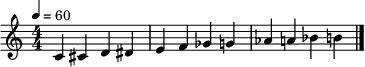

Cannot connect to server socket err = No such file or directory
Cannot connect to server request channel
jack server is not running or cannot be started
JackShmReadWritePtr::~JackShmReadWritePtr - Init not done for -1, skipping unlock
JackShmReadWritePtr::~JackShmReadWritePtr - Init not done for -1, skipping unlock


rtaudio: pulseaudio module enabled
--Csound version 6.18 (double samples) Oct  1 2022
[commit: ac38f27d1c5d6ee0cacc1bc719e96be3a2d93a15]
libsndfile-1.0.31
sr = 44100.0, kr = 689.062, ksmps = 64
0dBFS level = 1.0, A4 tuning = 442.0
audio buffered in 1024 sample-frame blocks
PulseAudio input server: default
reading 4096-byte blks of shorts from adc (RAW)
PulseAudio output server: default
pulseaudio output open
writing 2048 sample blks of 64-bit floats to dac
SECTION 1:


Button(description='Stop', style=ButtonStyle())

Output()

SynthGroup(n=12)
    Synth(𝍪 preset._piano:501.0002, p4=0 idataidx_:5=15 inumbps:6=2 ibplen:7=3 igain:8=1 ichan:9=1 ipos:10=-1 ifadein:11=0.02 ifadeout:12=0.02 ipchintrp_:13=0 ifadekind:14=1 p15=0 p16=60 ...)
    Synth(𝍪 preset._piano:501.0003, p4=0 idataidx_:5=15 inumbps:6=2 ibplen:7=3 igain:8=1 ichan:9=1 ipos:10=-1 ifadein:11=0.02 ifadeout:12=0.02 ipchintrp_:13=0 ifadekind:14=1 p15=0 p16=61 ...)
    Synth(𝍪 preset._piano:501.0004, p4=0 idataidx_:5=15 inumbps:6=2 ibplen:7=3 igain:8=1 ichan:9=1 ipos:10=-1 ifadein:11=0.02 ifadeout:12=0.02 ipchintrp_:13=0 ifadekind:14=1 p15=0 p16=62 ...)
    Synth(𝍪 preset._piano:501.0005, p4=0 idataidx_:5=15 inumbps:6=2 ibplen:7=3 igain:8=1 ichan:9=1 ipos:10=-1 ifadein:11=0.02 ifadeout:12=0.02 ipchintrp_:13=0 ifadekind:14=1 p15=0 p16=63 ...)
    Synth(𝍪 preset._piano:501.0006, p4=0 idataidx_:5=15 inumbps:6=2 ibplen:7=3 igain:8=1 ichan:9=1 ipos:10=-1 ifadein:11=0.02 ifadeout:12=0.02 ipchintrp_:13=0 ifadekind:14=1 p15=0 p16=64 ...)
    Synth(𝍪 preset._piano:501.0007, p4=0 idataidx_:5=15 inumbps:6=2 ibplen:7=3 igain:8=1 ichan:9=1 ipos:10=-1 ifadein:11=0.02 ifadeout:12=0.02 ipchintrp_:13=0 ifadekind:14=1 p15=0 p16=65 ...)
    Synth(𝍪 preset._piano:501.0008, p4=0 idataidx_:5=15 inumbps:6=2 ibplen:7=3 igain:8=1 ichan:9=1 ipos:10=-1 ifadein:11=0.02 ifadeout:12=0.02 ipchintrp_:13=0 ifadekind:14=1 p15=0 p16=66 ...)
    Synth(𝍪 preset._piano:501.0009, p4=0 idataidx_:5=15 inumbps:6=2 ibplen:7=3 igain:8=1 ichan:9=1 ipos:10=-1 ifadein:11=0.02 ifadeout:12=0.02 ipchintrp_:13=0 ifadekind:14=1 p15=0 p16=67 ...)
    Synth(𝍪 preset._piano:501.001, p4=0 idataidx_:5=15 inumbps:6=2 ibplen:7=3 igain:8=1 ichan:9=1 ipos:10=-1 ifadein:11=0.02 ifadeout:12=0.02 ipchintrp_:13=0 ifadekind:14=1 p15=0 p16=68 ...)
    Synth(𝍪 preset._piano:501.0011, p4=0 idataidx_:5=15 inumbps:6=2 ibplen:7=3 igain:8=1 ichan:9=1 ipos:10=-1 ifadein:11=0.02 ifadeout:12=0.02 ipchintrp_:13=0 ifadekind:14=1 p15=0 p16=69 ...)
    Synth(𝍪 preset._piano:501.0012, p4=0 idataidx_:5=15 inumbps:6=2 ibplen:7=3 igain:8=1 ichan:9=1 ipos:10=-1 ifadein:11=0.02 ifadeout:12=0.02 ipchintrp_:13=0 ifadekind:14=1 p15=0 p16=70 ...)
    Synth(𝍪 preset._piano:501.0013, p4=0 idataidx_:5=15 inumbps:6=2 ibplen:7=3 igain:8=1 ichan:9=1 ipos:10=-1 ifadein:11=0.02 ifadeout:12=0.02 ipchintrp_:13=0 ifadekind:14=1 p15=0 p16=71 ...)

In [2]:
scale = Chain([Note(m, dur=1) for m in range(60, 72)])
scale.show()
scale.play()

OfflineRenderer(sr=48000)
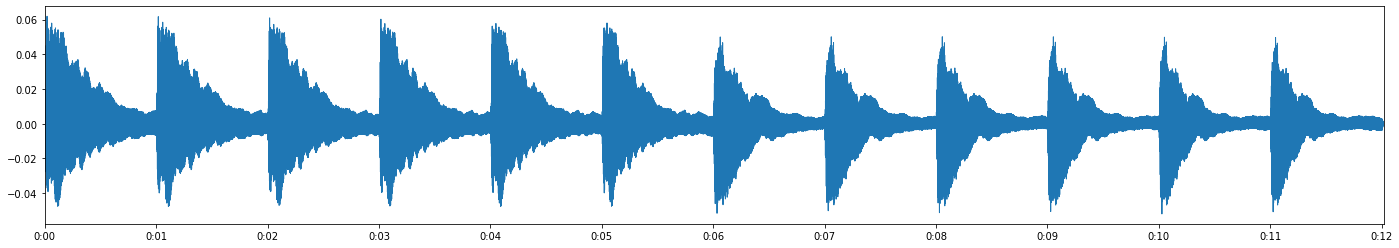

In [11]:
conf['rec.quiet'] = True  # do not output debugging info when rendering audio
conf['rec.sr'] = 48000     # set default recording samplerate
scale.rec('snd/scale-with-new-default-instr.ogg',nchnls=1)

----------------

## Workspace

At any moment there is one (and only one) active workspace. A workspace contains the following attributes:

* `.config` (`CoreConfig`): a config 
* `.scorestruct` (`ScoreStruct`): a score structure 
* `.dynamicCurve`: a dynamics curve, mapping dynamics to amplitudes
* internal attributes which determine the current state

In [12]:
w = getWorkspace()
w

Workspace(name=root, scorestruct=ScoreStruct(tempo=60, timesig=(4, 4)), dynamicCurve=DynamicCurve(shape=expon(0.3), mindb=-60.0, maxdb=0.0))

In [13]:
if w.isActive():
    print("This is the active workspace")

if w.config is getConfig():
    print("Its config is active")
    

This is the active workspace
Its config is active


By default a new Workspace includes a score structure of 4/4, quarter=60 bpm

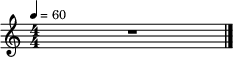

In [14]:
w.scorestruct.show()

By modifiying the `.scorestruct` attribute or using the `setScoreStruct()` function it is possible to change the active score struct. Any playback or notation operation will now refer to this new score structure

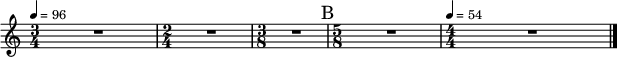

In [15]:
w.scorestruct = ScoreStruct('3/4, 96; 2/4; 3/8; 5/8,,B; 4/4, 54')
w.scorestruct.show()

The same scale from before will now be fitted to the new structure

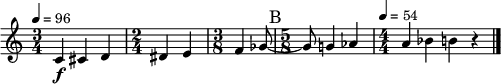

OfflineRenderer(sr=48000)
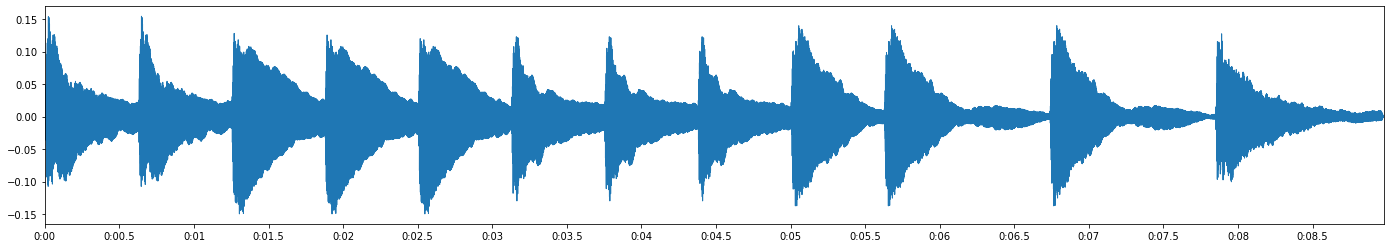

In [16]:
scale.show()
scale.rec(instr='piano', quiet=True, wait=True, nchnls=1)

## Ad-hoc contexts

It is possible to create a Workspace for an ad-hoc operation. After exiting the context the previous state is reset

In [9]:
scale.play(instr='tri')


error: syntax error, unexpected '|'  (token "|")
ERROR:csoundengine:compileOrcAsync error: 
 line 38:
 >>> |  <<<
Parsing failed due to invalid input!
Stopping on parser failure
ERROR:csoundengine:001  
002  instr 502  
003      atstop 1, 0.01, 0.0, p1
004  ;5        6       7      8      9     0    1       2        3          4        
005  idataidx_,inumbps,ibplen,igain,ichan,ipos,ifadein,ifadeout,ipchintrp_,ifadekind passign 5
006  idatalen_ = inumbps * ibplen
007  iArgs[] passign idataidx_, idataidx_ + idatalen_
008  ilastidx = idatalen_ - 1
009  iTimes[]     slicearray iArgs, 0, ilastidx, ibplen
010  iPitches[]   slicearray iArgs, 1, ilastidx, ibplen
011  iAmps[]      slicearray iArgs, 2, ilastidx, ibplen
012  
013  k_time = (timeinstk() - 1) * ksmps/sr  ; use eventtime (csound 6.18)
014  
015  if ipchintrp_ == 0 then      
016      ; linear midi interpolation    
017      kpitch, kamp bpf k_time, iTimes, iPitches, iAmps
018      kfreq mtof kpitch
019  elseif (ipchintrp_ == 1) th

CsoundError: Could not compile body for instr preset.tri

Pulse audio module error: Connection terminated


Exiting python, closing all active engines
... stopping maelzel.core


Csound tidy up: Terminated


In [8]:
scale.rec(instr='tri', gain=0.1, wait=True, nchnls=1)

OfflineRenderer(sr=44100)

In [19]:
with Workspace(updates={'play.instr': 'saw'}, scorestruct=ScoreStruct('3/4, 144; ...')):
    scale.show()
    display(scale.rec(gain=0.1, wait=True, nchnls=1))

print("Now we are outside the context, so the previous workspace is active again")
scale.show()

OfflineRenderer(sr=44100)

Now we are outside the context, so the previous workspace is active again


If you only need to modify the config or the scorestructure for an ad-hoc operation it is possible to create a context with just one of them:

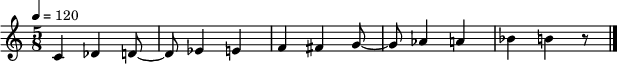

In [36]:
with ScoreStruct(timesig=(5, 8), quarterTempo=120):
    scale.play()
    scale.show()

In [6]:
with CoreConfig({'play.instr': 'saw'}):
    display(scale.rec(gain=0.1, wait=True, quiet=True, nchnls=1))

/home/em/dev/python/maelzel/maelzel/core/workspace.py:520: UserWarning: Decreated, use the constructor  CoreConfig instead
  warnings.warn("Decreated, use the constructor  CoreConfig instead")


OfflineRenderer(sr=44100)

Or you can use multiple contexts at the same time

............... 2
............... 2
............... 2
............... 2
............... 2


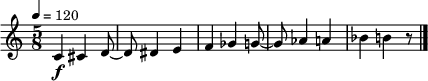

OfflineRenderer(sr=44100)

In [7]:
with ScoreStruct(timesig=(5, 8), quarterTempo=120), makeConfig({'play.instr': 'saw'}):
    scale.show()
    display(scale.rec(gain=0.1, wait=True, nchnls=1))